# Titanic: Machine Learning from Disaster 

# Introduction

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

**Import libraries:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()
pd.set_option('display.max_columns', 2500, 'display.max_rows', 2500, 'display.width', None)

**Read the data:**

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train.name = 'Training set'
test.name = 'Test set'

**Define functions:**

In [3]:
def distribution(value):
    df = pd.DataFrame({value: train[value].value_counts().index, 'Number': train[value].value_counts().values})
    if df[value].dtypes != 'object':
        df[value] = df[value].round()
        df = df.sort_values(value)
        df = df.groupby([value])['Number'].sum().reset_index(drop=False)
    if value == 'Embarked':
        df[value] = df[value].replace('S', 'Southampton').replace('C', 'Cherbourg').replace('Q', 'Queenstown')

    plt.figure()
    plt.style.use('seaborn-darkgrid')
    plt.bar(df[value], df['Number'])
    plt.title('Distribution of {}'.format(value), fontsize=12)
    plt.xlabel(value, fontsize=12), plt.ylabel('Number of passengers', fontsize=12)
    plt.yticks(fontsize=12)
    if value == 'Pclass':
        plt.xticks([1, 2, 3])
    plt.show()

def missing_after(value):
    for column in value:
        print('{}:'.format(column), value[column].isna().sum())

# 1. Exploratory Data Analysis

## 1.1 Overview

In [4]:
print('Training set: {} observations'.format(len(train)))
print('Test set: {} observations'.format(len(test)))
print('\nColumns:', list(train.columns))

Training set: 891 observations
Test set: 418 observations

Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


## 1.2 Descriptive statistics

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 1.3 Features

In [6]:
print('Missing values initially:')
for dataset in (train, test):
    print('\n{}:'.format(dataset.name))
    for column in dataset:
        print('{}:'.format(column), dataset[column].isna().sum())

Missing values initially:

Training set:
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2

Test set:
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 86
SibSp: 0
Parch: 0
Ticket: 0
Fare: 1
Cabin: 327
Embarked: 0


**1.3.1 Feature *Sex***

74.2% of female passengers survived
18.9% of male passengers survived


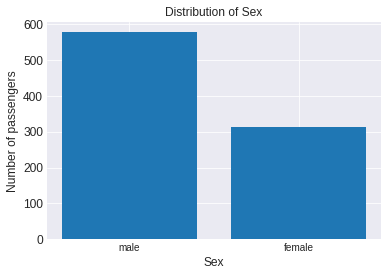

In [7]:
# Survival rate per Sex
survival_rate_sex = train.groupby(['Sex'])['Survived'].mean()
for index, value in survival_rate_sex.items():
    print('{}% of {} passengers survived'.format(round(value * 100, 1), index))
    
distribution('Sex')

In [8]:
# Sex to numerical variable for correlation matrix 
labelEncoder = LabelEncoder()
train['Sex'] = labelEncoder.fit_transform(train['Sex']) # male=1, female=0
test['Sex'] = labelEncoder.fit_transform(test['Sex']) # male=1, female=0

**1.2.2 Feature *Pclass***

63.0% of passengers in Pclass 1 survived
47.3% of passengers in Pclass 2 survived
24.2% of passengers in Pclass 3 survived


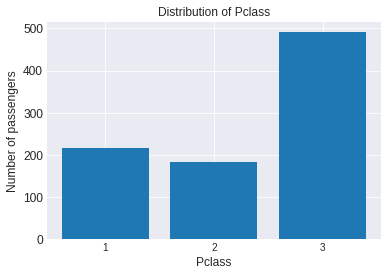

In [9]:
# Survival rate per Pclass
survival_rate_pclass = train.groupby(['Pclass'])['Survived'].mean()
for index, value in survival_rate_pclass.items():
    print('{}% of passengers in Pclass {} survived'.format(round(value * 100, 1), index))


distribution('Pclass')

**1.3.3 Feature *Age***

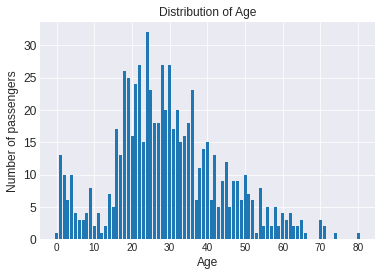

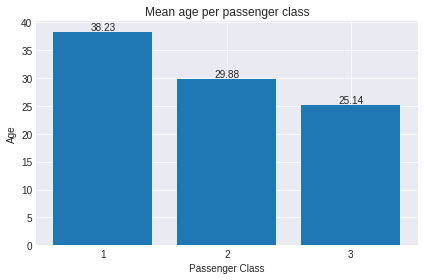

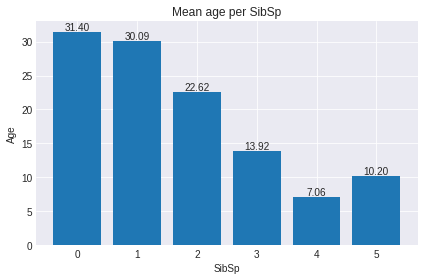

In [10]:
distribution('Age')

age_per_pclass = train.groupby('Pclass')['Age'].mean()

plt.figure()
plt.style.use('seaborn-darkgrid')
plt.bar(age_per_pclass.index, age_per_pclass.values)
plt.title('Mean age per passenger class'), plt.xlabel('Passenger Class'), plt.ylabel('Age')
plt.xticks([1, 2, 3])
for i, v in enumerate(np.array(age_per_pclass)):
    plt.text(i+1, v + 0.25, str('%.2f' % v), ha='center', fontsize=10)  # Force every value to have 2 decimal places
plt.tight_layout()
plt.show()

age_per_sibsp = train.groupby('SibSp')['Age'].mean()

plt.figure()
plt.style.use('seaborn-darkgrid')
plt.bar(age_per_sibsp.index, age_per_sibsp.values)
plt.title('Mean age per SibSp'), plt.xlabel('SibSp'), plt.ylabel('Age')
for i, v in enumerate(np.array(age_per_sibsp)):
    plt.text(i, v + 0.25, str('%.2f' % v), ha='center', fontsize=10)  # Force every value to have 2 decimal places
plt.tight_layout()
plt.show()

**1.3.4 Feature *Fare***

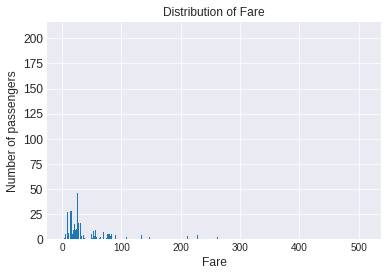

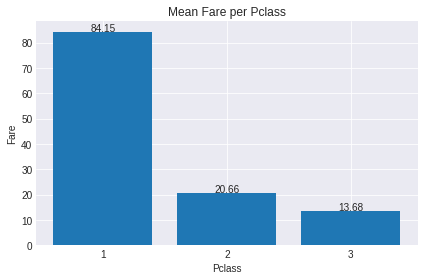

In [11]:
distribution('Fare')

fare_per_pclass = train.groupby('Pclass')['Fare'].mean()

plt.figure()
plt.style.use('seaborn-darkgrid')
plt.bar(fare_per_pclass.index, fare_per_pclass.values)
plt.title('Mean Fare per Pclass'), plt.xlabel('Pclass'), plt.ylabel('Fare')
plt.xticks([1, 2, 3])
for i, v in enumerate(np.array(fare_per_pclass)):
    plt.text(i+1, v + 0.25, str('%.2f' % v), ha='center', fontsize=10)  # Force every value to have 2 decimal places
plt.tight_layout()
plt.show()

1.3.5 Features *Embarked*, *SibSp* & *Parch*

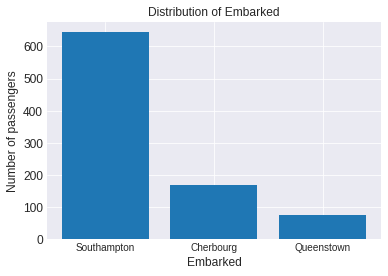

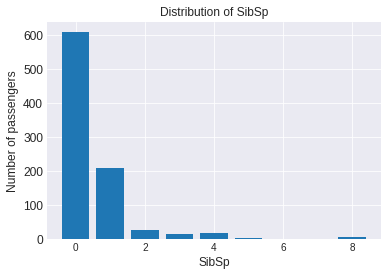

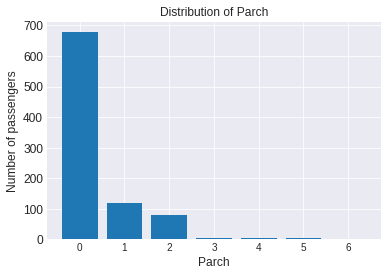

In [12]:
distribution('Embarked')
distribution('SibSp')
distribution('Parch')

## 1.4 Correlations

Correlations may yield insights for cleaning the missing values in *Age* and *Fare*.

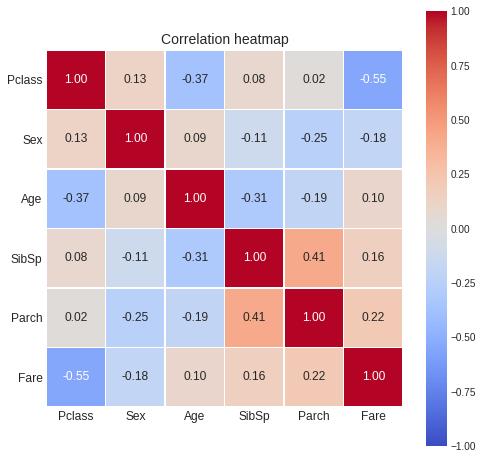

In [13]:
# Correlation matrix
correlation_matrix = train.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
correlation_matrix = correlation_matrix.astype(float).corr()

# Correlation heatmap
plt.figure(figsize=(8,8))
#sns.set(font_scale=0.75)
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center=0, linewidths=0.5, cmap='coolwarm', square=True, annot=True, fmt='.2f', annot_kws={"size": 12})
plt.xticks(fontsize=12), plt.yticks(rotation=0, ha='right', fontsize=12), plt.title('Correlation heatmap', fontsize=14)
plt.show()

Finding: *Age* correlates most with *Pclass* and *SibSp*, *Fare* correlates most with *Pclass*.

# 2. Data preprocessing

## 2.1 Data cleaning

- Missing values in *Age* are replaced with the mean of the respective *Pclass*
- Missing values in *Fare* are replaced with the mean of the respective *Pclass*
- Missing values in *Embarked* are replaced with 'Unknown'

In [14]:
# Clean missing values in Age with mean of the respective Pclass
train['Age'] = train['Age'].fillna(train.groupby('Pclass')['Age'].transform('mean'))
test['Age'] = test['Age'].fillna(train.groupby('Pclass')['Age'].transform('mean'))

# Clean missing values in Fare with mean of the respective Pclass
test['Fare'] = test['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('mean'))

# Clean missing values in Embarked with Unknown
train['Embarked'] = train['Embarked'].fillna('Unknown')

print('Missing values after cleaning:')
print('\nTraining set:'), missing_after(train)
print('\nTest set:'), missing_after(test)

Missing values after cleaning:

Training set:
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 0
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 0

Test set:
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 0
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 327
Embarked: 0


(None, None)

## 2.2 Feature engineering

2.2.1 Feature *Title*

The column *Name* contains the title of every passenger on board of the Titanic. While the name is assumed to have no effect on whether a passenger will survive, the tilte may be relevant when it comes to predicting survival.

In [15]:
train.loc[:10, ('PassengerId','Name')]

,PassengerId,Name
0,1,"Braund, Mr. Owen Harris"
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,3,"Heikkinen, Miss. Laina"
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,5,"Allen, Mr. William Henry"
5,6,"Moran, Mr. James"
6,7,"McCarthy, Mr. Timothy J"
7,8,"Palsson, Master. Gosta Leonard"
8,9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
9,10,"Nasser, Mrs. Nicholas (Adele Achem)"


There dataset initially contained many different titles. Most of them appear only once or twice. Therefore, the titles have been standardized to the most commong titles.

In [16]:
# Feature Title
for dataset in (train, test):
    print('{}:'.format(dataset.name))
    dataset['Title'] = dataset['Name'].str.split(',').str[1]
    dataset['Title'] = dataset['Title'].str.split('.').str[0]
    dataset['Title'] = dataset['Title'].str.replace(' ', '')
    
    print('There are {} different titles:'.format(dataset['Title'].nunique()))

    for i in list(dataset['Title'].unique()):
        print('{}:'.format(i), sum(dataset['Title'] == i))

    # Standardize titles
    dataset['Title'] = dataset['Title'].str.replace('Ms|Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].str.replace('Dona|theCountess|Lady|Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].str.replace('Capt|Col|Don|Jonkheer|Major|Mrt|Rev|Sir', 'Mr')
    
    print('')

Training set:
There are 17 different titles:
Mr: 517
Mrs: 125
Miss: 182
Master: 40
Don: 1
Rev: 6
Dr: 7
Mme: 1
Ms: 1
Major: 2
Lady: 1
Sir: 1
Mlle: 2
Col: 2
Capt: 1
theCountess: 1
Jonkheer: 1

Test set:
There are 9 different titles:
Mr: 240
Mrs: 72
Miss: 78
Master: 21
Ms: 1
Col: 2
Rev: 2
Dr: 1
Dona: 1



While the sex is obvious for most titles, this is not the case for 'Dr'. Further analysis is required to check whether 'Dr' belongs to one or both sexes.

In [17]:
for dataset in (train, test):
    print('{}:'.format(dataset.name))
    print('Detailed analysis of Dr:')
    print(dataset.loc[:, ('PassengerId', 'Name', 'Title')][dataset['Title'] == 'Dr'])
    print('')

Training set:
Detailed analysis of Dr:
     PassengerId                           Name Title
245          246    Minahan, Dr. William Edward    Dr
317          318           Moraweck, Dr. Ernest    Dr
398          399               Pain, Dr. Alfred    Dr
632          633      Stahelin-Maeglin, Dr. Max    Dr
660          661  Frauenthal, Dr. Henry William    Dr
766          767      Brewe, Dr. Arthur Jackson    Dr
796          797    Leader, Dr. Alice (Farnham)    Dr

Test set:
Detailed analysis of Dr:
     PassengerId                   Name Title
293         1185  Dodge, Dr. Washington    Dr



Result: Mr, Mrs, Miss, Master

In [18]:
# Replace female Dr with Mrs and male Dr with Mr
for dataset in (train, test):
    print('{}:'.format(dataset.name))
    dataset.loc[(dataset['Sex'] == 1) & (dataset['Title'] == 'Dr'), 'Title'] = 'Mr'
    dataset.loc[(dataset['Sex'] == 0) & (dataset['Title'] == 'Dr'), 'Title'] = 'Mrs'

    # Result: Mr, Mrs, Miss, Master
    for i in list(dataset['Title'].unique()):
        print('{}:'.format(i), sum(dataset['Title'] == i))
    print('')

Training set:
Mr: 537
Mrs: 129
Miss: 185
Master: 40

Test set:
Mr: 245
Mrs: 73
Miss: 79
Master: 21



2.2.2 Feature *Ttype*

There may be a logic in column *Ticket*. Most tickets only contain numbers while their are groups of other ticket types, such as 'A/5', 'PC' or 'STON'. 'STON' may indicate 'Southhampton'. This is already captured in the column *Embarked*. However, the ticket types may contain information that help to learn algorithm to make more accurate predictions.

In [19]:
train.loc[:, ('PassengerId', 'Ticket')][:10]

,PassengerId,Ticket
0,1,A/5 21171
1,2,PC 17599
2,3,STON/O2. 3101282
3,4,113803
4,5,373450
5,6,330877
6,7,17463
7,8,349909
8,9,347742
9,10,237736


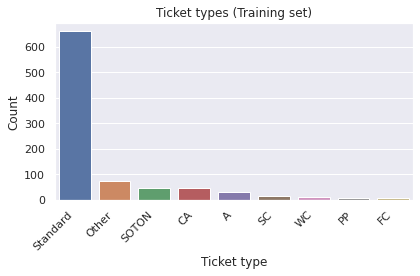

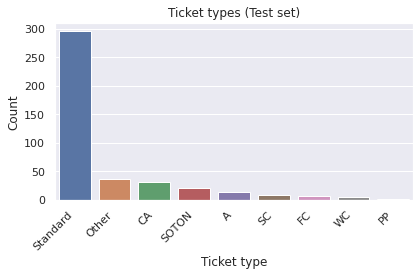

In [20]:
# Feature Ticket type
for dataset in (train, test):
    dataset['Ttype'] = dataset['Ticket']
    ticket = [('STON|SOTON|S.O|SO/C|S.O', 'SOTON'), ('C.A|CA', 'CA'), ('PP', 'PP'), ('S.C|SC', 'SC'), ('W./C.|W/C|WC','WC'),
             ('A/|A.', 'A'), ('F.C.', 'FC'), ('Fa|W.E.P|SW|S.W.|WE/P|S.P.|C |LP|LINE', 'Other')]

    for string in ticket:
        dataset.loc[dataset['Ttype'].str.contains(string[0]), 'Ttype'] = string[1]

    # Replace columns containing numbers only with Number
    dataset['Ttype'] = dataset['Ttype'].str.replace('[0123456789]', '')
    dataset.loc[dataset['Ttype'] == '', 'Ttype'] = 'Standard'

    sns.set(style='darkgrid')
    sns.countplot(dataset['Ttype'], order=dataset['Ttype'].value_counts().index)
    plt.title('Ticket types ({})'.format(dataset.name)), plt.ylabel('Count'), plt.xlabel('Ticket type')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

2.2.3 Feature *Deck*

Similar to the *Ttype*, the cabin may capture important information. Research has shown that the letter in the column *Cabin* indicates the deck. Some decks are in the bottom of the Titanic which is expected to affect the chance of survival.

In [21]:
train.loc[:, ('PassengerId', 'Cabin')][:10]

,PassengerId,Cabin
0,1,NaN
1,2,C85
2,3,NaN
3,4,C123
4,5,NaN
5,6,NaN
6,7,E46
7,8,NaN
8,9,NaN
9,10,NaN


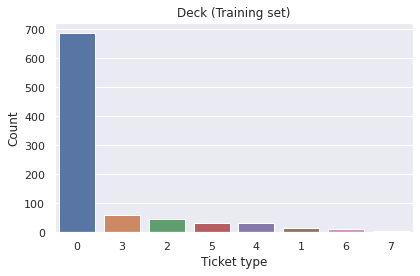

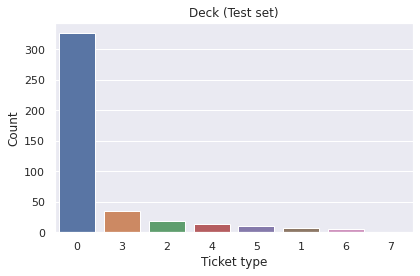

In [22]:
for dataset in (train, test):
    # Create new column and replace NaNs by Unknown
    dataset['Deck'] = dataset['Cabin']
    dataset['Deck'] = dataset['Deck'].fillna(0)

    # Keep the letter indicating the Deck and drop the number indicating the Cabin number
    cabin = [('A', 1), ('B', 2), ('C', 3), ('D', 4), ('E', 5), ('F', 6), ('G', 7)]

    for string in cabin:
        dataset.loc[dataset['Deck'].str.contains(string[0], na=False), 'Deck'] = string[1]

    # Replace Deck T by Unknown since T is no deck
    dataset['Deck'] = dataset['Deck'].replace('T', 0)

    # Plot: of final Deck values
    sns.set(style='darkgrid')
    sns.countplot(dataset['Deck'], order=dataset['Deck'].value_counts().index)
    plt.title('Deck ({})'.format(dataset.name)), plt.ylabel('Count'), plt.xlabel('Ticket type')
    plt.tight_layout()
    plt.show()


Unfortunately, the performance turned out to decrease when the model was trained with the feature *Deck*.

## 2.3 Polynomial features

Polynomial features are very powerful for identifying interaction effects within the data. Thereby, the algorithm can nonlinear effects when it is trained with linear data. The algorithm could identify that young and old passengers, but no passengers with middle age, have a high chance of survival.

In [23]:
poly = PolynomialFeatures(3)
poly_train = pd.DataFrame(poly.fit_transform(train.loc[:, ('Age', 'Fare')]),
                          columns=poly.get_feature_names(train.loc[:, ('Age', 'Fare')].columns))
train = pd.concat([train, poly_train.loc[:, 'Age^2':'Fare^3']], ignore_index=False, axis=1, sort=False)

poly_test = pd.DataFrame(poly.fit_transform(test.loc[:, ('Age', 'Fare')]),
                         columns=poly.get_feature_names(test.loc[:, ('Age', 'Fare')].columns))
test = pd.concat([test, poly_test.loc[:, 'Age^2':'Fare^3']], ignore_index=False, axis=1, sort=False)



## 2.4 Feature scaling for numerical columns

Most ML algorithms do not perform well when the input numerical attributes have very different scales. The values need to scaled.

In [24]:
for dataset in (train, test):
    for column in dataset.loc[:, 'Pclass':]:  # start with Pclass
        if dataset[column].dtypes == 'float64' or dataset[column].dtypes == 'int64':
            dataset[column] = MinMaxScaler().fit_transform(dataset[[column]])

## 2.5 Label encoding and one-hot encoding

Furthermore, ML algorithms prefer to work with numbers. Let's convert the text labels into numbers! Features with more than two different text labels need to be scaled with one-hot encoding and not with label encoding. Otherwise, the model would assume that two nearby values are more similar than two distant values which is not the case.

In [25]:
# Label encoding (categorical variables with two values)
labelEncoder = LabelEncoder()
train['Sex'] = labelEncoder.fit_transform(train['Sex'])
test['Sex'] = labelEncoder.fit_transform(test['Sex'])

# One hot encoding (categorical variables with more than two values) # abstract the code
one_hot_encoding_train = pd.get_dummies(train[['Pclass', 'Embarked', 'Title', 'Ttype']])
train = pd.concat([train, one_hot_encoding_train], ignore_index=False, axis=1, sort=False)
one_hot_encoding_test = pd.get_dummies(test[['Pclass', 'Embarked', 'Title', 'Ttype']])
test = pd.concat([test, one_hot_encoding_test], ignore_index=False, axis=1, sort=False)


## 2.6 Prepare the data

**2.6.1 Estimators**

In [26]:
X_train = pd.concat([train.loc[:, 'Sex':'Age'], train.loc[:, 'Age^2':'Embarked_S'], train.loc[:, 'Title_Master':'Ttype_WC']], axis=1, sort=False)
X_test = pd.concat([test.loc[:, 'Sex':'Age'], test.loc[:, 'Age^2':'Embarked_S'], test.loc[:, 'Title_Master':'Ttype_WC']], axis=1, sort=False)

# Training and validation set to estimate generalization performance
training, validation = train_test_split(train, test_size=0.2)

X_training = pd.concat([training['Pclass'], training.loc[:, 'Sex':'Age'], training.loc[:, 'Age^2':'Embarked_S'], training.loc[:, 'Title_Master':'Ttype_WC']], axis=1, sort=False)
X_validation = pd.concat([validation['Pclass'], validation.loc[:, 'Sex':'Age'], validation.loc[:, 'Age^2':'Embarked_S'], validation.loc[:, 'Title_Master':'Ttype_WC']], axis=1, sort=False)

In [27]:
X_train[:5]

,Sex,Age,Age^2,Age Fare,Fare^2,Age^3,Age^2 Fare,Age Fare^2,Fare^3,Pclass,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Ttype_A,Ttype_CA,Ttype_FC,Ttype_Other,Ttype_PP,Ttype_SC,Ttype_SOTON,Ttype_Standard,Ttype_WC
0,1,0.271174,0.075600,0.008648,0.000200,0.020797,0.003257,0.000122,0.000003,1.0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
1,0,0.472229,0.225604,0.146865,0.019359,0.107172,0.095552,0.020434,0.002693,0.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0.321438,0.105600,0.011172,0.000239,0.034328,0.004973,0.000173,0.000004,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0.434531,0.191384,0.100765,0.010742,0.083740,0.060383,0.010444,0.001113,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0.434531,0.191384,0.015276,0.000247,0.083740,0.009154,0.000240,0.000004,1.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0


**2.6.2 Target value *Survived***

In [28]:
y_train = np.ravel(train[['Survived']])
y_training = np.ravel(training[['Survived']])
y_validation = np.ravel(validation[['Survived']])

# 3. Model selection

## 3.1 Generalization performance of different models

In [29]:
logistic_regression = LogisticRegressionCV(scoring='accuracy', penalty='l1', solver='saga', Cs=50, cv=5, max_iter=10000)
logistic_regression.name = 'Logistic regression'
random_forest = RandomForestClassifier(n_estimators=200, max_features=15, max_depth=10, min_samples_leaf=3)
random_forest.name = 'Random forest'
support_vector_machine = svm.SVC(C=1.5, kernel='rbf', gamma='scale', probability=True)
support_vector_machine.name = 'Support vector machine'
gradient_boosting = GradientBoostingClassifier(loss='deviance', learning_rate=0.03, n_estimators=200, criterion='friedman_mse')
gradient_boosting.name = 'Gradient boosting'
naive_bayes = GaussianNB()
naive_bayes.name = 'Naive bayes'

comparison = pd.DataFrame({'Model': [], 'Training score': [], 'Validation score': []})

for model in [random_forest, logistic_regression, support_vector_machine, gradient_boosting, naive_bayes]:
    model.fit(X_training, y_training)
    prediction_training = pd.DataFrame({'PassengerId': training['PassengerId'], 'Actual': y_training,
                                        'Prediction Classification': model.predict(X_training)})
    prediction_validation = pd.DataFrame({'PassengerId': validation['PassengerId'], 'Actual': y_validation,
                                          'Prediction Classification': model.predict(X_validation)})

    accuracy_training = round(model.score(X_training, y_training), 3)
    accuracy_validation = round(model.score(X_validation, y_validation), 3)

    results = pd.DataFrame({'Model': [model.name], 'Training score': [accuracy_training], 'Validation score': [accuracy_validation]})
    comparison = comparison.append(results, ignore_index=True)

comparison.sort_values(by='Validation score', ascending=False).reset_index(drop=True)

,Model,Training score,Validation score
0,Gradient boosting,0.897,0.827
1,Support vector machine,0.841,0.821
2,Random forest,0.909,0.816
3,Logistic regression,0.820,0.799
4,Naive bayes,0.754,0.737


# 4. Model evaluation

Train the models on the entire training set

In [30]:
random_forest.fit(X_train, y_train)
logistic_regression.fit(X_train, y_train)
support_vector_machine.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 4.1 Random forest

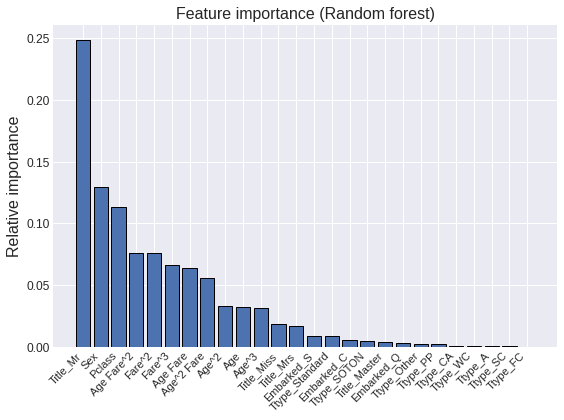

In [31]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Relative Importance': random_forest.feature_importances_})
# Sort by absolute coefficient values and calculate relative importance
feature_importance = feature_importance.iloc[
    feature_importance['Relative Importance'].abs().argsort()[::-1]].reset_index(drop=True)

plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')
plt.bar(feature_importance['Feature'], feature_importance['Relative Importance'], edgecolor='black')
plt.title('Feature importance (Random forest)', fontsize=16), plt.ylabel('Relative importance', fontsize=16)
if len(list(feature_importance['Relative Importance'])) < 15:
    for i, v in enumerate(np.around(np.array(feature_importance['Relative Importance']), 4)):
        plt.text(i, v + 0.003, str('%.4f' % v), ha='center', fontsize=10)  # Force every value to have 2 decimal places
plt.xticks(rotation=45, ha='right'), plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## 4.2 Support vector machine

Probabilities for 0 and 1 of the first 10 test set examples:

In [32]:
probability = support_vector_machine.predict_proba(X_test[:10])
pd.DataFrame({'Survived': probability[:, 0], 'Not survived': probability[:, 1]})

,Survived,Not survived
0,0.826087,0.173913
1,0.562500,0.437500
2,0.836244,0.163756
3,0.825863,0.174137
4,0.576650,0.423350
5,0.827174,0.172826
6,0.182513,0.817487
7,0.825835,0.174165
8,0.173556,0.826444
9,0.826288,0.173712


## 4.3 Logistic regression

In [33]:
best_parameter = str(np.around(logistic_regression.C_, 5)).lstrip('[').rstrip(']')
scores_logistic_regression = pd.DataFrame(logistic_regression.scores_[1])
best_coefficients = pd.Series(list(logistic_regression.coef_.flat), index=X_train.columns)

print('Result: At the best regularization parameter', best_parameter,
      'Logistic regression set', sum(best_coefficients.values == 0), 'of the', len(best_coefficients),
      'features equal to zero.')

best_coefficients.abs()

Result: At the best regularization parameter 1048.11313 Logistic regression set 0 of the 26 features equal to zero.


Sex                0.167420
Age                1.936987
Age^2              7.981194
Age Fare           2.839550
Fare^2            22.242476
Age^3              4.295234
Age^2 Fare         1.417285
Age Fare^2         4.453993
Fare^3            21.651354
Pclass             2.645604
Embarked_C         2.366376
Embarked_Q         2.464093
Embarked_S         2.942141
Title_Master       0.000001
Title_Miss         0.099295
Title_Mr           2.581223
Title_Mrs          0.532443
Ttype_A            0.341442
Ttype_CA           0.289987
Ttype_FC           0.434411
Ttype_Other        0.086033
Ttype_PP           2.129157
Ttype_SC           0.191552
Ttype_SOTON        0.600011
Ttype_Standard     0.025551
Ttype_WC           1.876400
dtype: float64

## 4.4 Predict survival

Although the random forest achieves the highest validation score, the support vetor machine turned out to perform best on the test data and is thus used to predict survival.

In [34]:
# Make random forest predictions
prediction_random_forest = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': random_forest.predict(X_test)})
prediction_random_forest.to_csv('titanic_random_forest.csv', index=False)

# Make logistic regression predictions
prediction_logistic_regression = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': logistic_regression.predict(X_test)})
prediction_logistic_regression.to_csv('titanic_logistic_regression.csv', index=False)

# Make support vector machine predictions
prediction_support_vector_machine = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': support_vector_machine.predict(X_test)})
prediction_support_vector_machine.to_csv('titanic_support_vector_machine.csv', index=False)